# Autonomous Vehicle: End-to-end Learning in Carla Environment

## Experiment: Dataset no_traffic_light

## Introduction

This notebook details an implementation of the Autonomous vehicle control: End-to-end Learning in Simulated Urban Environment presented in [(Hege H., Max A., Frank L., 2019)](https://arxiv.org/pdf/1905.06712.pdf).  This model is notable for small dataset that was collected from the simulation while the performance is not near the paper's, but it still do really well.

In [20]:
%reload_ext autoreload

In [21]:
%autoreload 2

In [22]:
import os
import timeit
import math

## Import the utils that will contain batch generator and data augmentation

In [23]:
import nbimporter # pip install nbimporter
import utils as utils
import importlib
importlib.reload(utils)

Importing Jupyter notebook from utils.ipynb


<module 'utils' from 'utils.ipynb'>

## Constructing the dataset

In [24]:
import pandas as pd
import numpy as np
import category_encoders as ce

We only need pandas for reading csv file, numpy for matrix math, and category_encoders for categorising the HLC (High Level Command) and tranform them it to 4 columns.

Function to load dataset from csv file. The categories (HLC) are converted to one-shot representation.

In [25]:
def load_data(folder_name):
    
    data_df = pd.read_csv(os.path.join('../../', '_out', folder_name, 'train', 'data.csv'))
    
    ce_one_shot = ce.OneHotEncoder(cols='high_level_command')
    data_df = ce_one_shot.fit_transform(data_df)

    X_train = data_df[['image_path', 'speed', 'high_level_command_1', 'high_level_command_2', 'high_level_command_3', 'high_level_command_4']].values
    Y_train = data_df[['throttle', 'steering_angle', 'brake']].values
    
    data_df = pd.read_csv(os.path.join('../../', '_out', folder_name, 'test', 'data.csv'))
    data_df = ce_one_shot.fit_transform(data_df)

    X_valid = data_df[['image_path', 'speed', 'high_level_command_1', 'high_level_command_2', 'high_level_command_3', 'high_level_command_4']].values
    Y_valid = data_df[['throttle', 'steering_angle', 'brake']].values
    
    
    print('X_train shape = (%d, %d)'% X_train.shape)
    print('Y_train shape = (%d, %d)'% Y_train.shape)
    print('X_valid shape = (%d, %d)'% X_valid.shape)
    print('Y_valid shape = (%d, %d)'% Y_valid.shape)

    return X_train, X_valid, Y_train, Y_valid

In [26]:
X_train, X_valid, Y_train, Y_valid = load_data('no_traffic_light')

FileNotFoundError: [Errno 2] File b'../../_out/no_traffic_light/train/data.csv' does not exist: b'../../_out/no_traffic_light/train/data.csv'

## Building model

In [ ]:
#keras is a high level wrapper on top of tensorflow (machine learning library)
#The Sequential container is a linear stack of layers
from keras.models import Model
#popular optimization strategy that uses gradient descent 
from keras.optimizers import Adam
#to save our model periodically as checkpoints for loading later
from keras.callbacks import ModelCheckpoint
#what types of layers do we want our model to have?
from keras.layers import Lambda, Conv2D, Dense, Flatten, LSTM, Activation, Cropping2D, Input, concatenate
from keras.layers.normalization import BatchNormalization
#for ploting graph
import matplotlib.pyplot as plt

We use keras for building the neural network.

Specify input shape for image.

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 180, 300, 3

The model consists of 2 connected modules:
1. Feature extractor: Using CNN to extract useful features from input image
2. Prediction module: Combining the detected features with the additional input (i.e., current speed and HLC) to predict a control signal (i.e., steering angle, throttle and brake values).

Activation: relu

In [10]:
def build_model(args):
    
    input_image = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), name='input_image')
    input_speed = Input(shape=(1, ), name='input_speed')
    input_command = Input(shape=(4, ), name='input_command')
    
    xc = Cropping2D(cropping=((70, 0), (0, 0)), name='cropping')(input_image)
    xc = Lambda(lambda x: x/127.5-1.5)(xc)
    
    xc = Conv2D(24, kernel_size=(5, 5), strides=(2, 2), name='conv_1')(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('relu')(xc)
    
    xc = Conv2D(36, kernel_size=(5, 5), strides=(2, 2), name='conv_2')(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('relu')(xc)
    
    xc = Conv2D(48, kernel_size=(5, 5), strides=(2, 2), name="conv_3")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('relu')(xc)
    
    xc = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), name="conv_4")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('relu')(xc)
    
    xc = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), name="conv_5")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('relu')(xc)
    
    xc = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), name="conv_6")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('relu')(xc)

    """Flatten"""
    x = Flatten()(xc)
    x = Activation('relu')(x)
    
    """fc 1"""
    x = Dense(100, name="fc_1")(x)
    x = Activation('relu')(x)


    # concatenate x, speed and cmd (joint sensory)
    j = concatenate([x, input_speed, input_command])
    
    """Action"""
    output = Dense(100, name="action_fc_1")(j)
    output = Activation('relu')(output)
    
    output = Dense(50, name="action_fc_2")(output)
    output = Activation('relu')(output)
    
    output = Dense(10, name="action_fc_3")(output)
    output = Activation('relu')(output)
    
    output = Dense(3, name="action_fc_4", activation="tanh")(output)
        
    model = Model(inputs=[input_image, input_speed, input_command], outputs=output)
    model.summary()

    return model

Specify number of num samples and batch size

In [ ]:
num_samples = 60000
batch_size = 40

args's dict contains values that will be used for training model 

In [ ]:
args = {
        'nb_epoch': 2,
        'samples_per_epoch': num_samples,
        'batch_size': batch_size,
        'save_best_only': True,
        'learning_rate': 1.0e-4,
        'steps_per_epoch': num_samples//batch_size
}

Building model

In [ ]:
model = build_model(args)

## Training the model

In [11]:
def train_model(model, args, X_train, X_test, Y_train, Y_test):
    """
    Train the model
    """
    #Saves the model after every epoch.
    #quantity to monitor, verbosity i.e logging mode (0 or 1), 
    #if save_best_only is true the latest best model according to the quantity monitored will not be overwritten.
    #mode: one of {auto, min, max}. If save_best_only=True, the decision to overwrite the current save file is
    # made based on either the maximization or the minimization of the monitored quantity. For val_acc, 
    #this should be max, for val_loss this should be min, etc. In auto mode, the direction is automatically
    # inferred from the name of the monitored quantity.
    callbacks = [ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=args['save_best_only'],
                                 mode='auto')]
    #calculate the difference between expected steering angle and actual steering angle
    #square the difference
    #add up all those differences for as many data points as we have
    #divide by the number of them
    #that value is our mean squared error! this is what we want to minimize via
    #gradient descent
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=args['learning_rate']), metrics=['accuracy'])

    #Fits the model on data generated batch-by-batch by a Python generator.

    #The generator is run in parallel to the model, for efficiency. 
    #For instance, this allows you to do real-time data augmentation on images on CPU in 
    #parallel to training your model on GPU.
    #so we reshape our data into their appropriate batches and train our model simulatenously
    history = model.fit_generator(utils.batch_generator(X_train, Y_train, args['batch_size'], True, args),
                                  steps_per_epoch=args['steps_per_epoch'], 
                                  epochs=args['nb_epoch'],
                                  validation_data=utils.batch_generator(X_valid, Y_valid, args['batch_size'], False, args),
                                  validation_steps=(X_test.shape[0])//(args['batch_size']), 
                                  callbacks=callbacks, shuffle=False)
    model.save('model.h5')

    return history

Function for plotting loss and accuracy

In [12]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

This is an example of image that will be used for this model
with the dimension of **180x300x3**

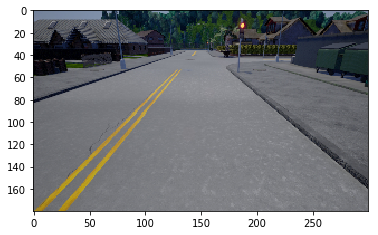

In [14]:
image = utils.load_image(X_train[100][0])
utils.show_image(utils.resize(image))

### Load train/validation data set and train the model

------------------------------
Parameters
------------------------------
learning_rate        := 0.0001
batch_size           := 40
save_best_only       := True
steps_per_epoch      := 1500
nb_epoch             := 2
samples_per_epoch    := 60000
------------------------------
Epoch 1/2
(11299, 6)
(11299, 3)
(60000, 6)
(60000, 3)
1500/1500 [==============================] - 2901s 2s/step - loss: 0.0298 - acc: 0.9296 - val_loss: 0.0379 - val_acc: 0.9351
Epoch 2/2
1500/1500 [==============================] - 2835s 2s/step - loss: 0.0183 - acc: 0.9446 - val_loss: 0.0339 - val_acc: 0.9348
------------------------------
Time use: 1 hours 35 minutes 37 seconds.
------------------------------


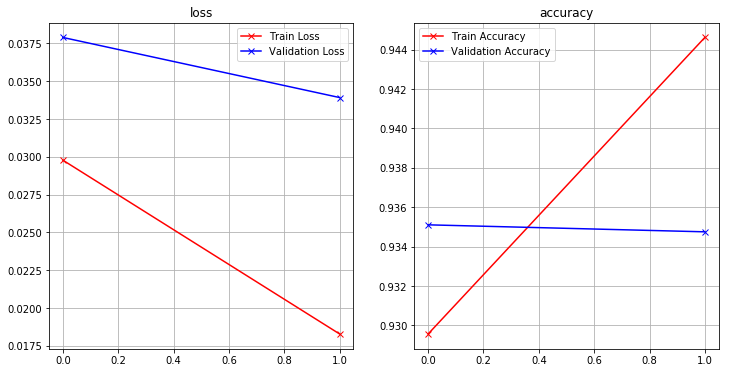

In [16]:
#print parameters
print('-' * 30)
print('Parameters')
print('-' * 30)
for key in args:
    print('{:<20} := {}'.format(key, args[key]))
print('-' * 30)

# train model on validation data, it saves as model.h5 
# Comment out when you finish validation and about to start the real training with test dataset
start = timeit.default_timer()
history = train_model(model, args, X_train, X_valid, Y_train, Y_valid)
stop = timeit.default_timer()
elasped = stop - start
hour = math.floor(elasped / 3600)
minute = math.floor((elasped - hour * 3600) / 60)
second = elasped - ((hour * 3600) + (minute * 60))
print('-' * 50)
print('Time use: %d hours %d minutes %d seconds.' % (hour, minute, second)) 
print('-' * 50)

### visualize training and validation

In [ ]:
plot_loss_accuracy(history)